In [1]:
import torch
from torch.nn import functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "meta-llama/Llama-3.2-1B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_name)

### Perplexity

In [ ]:
torch.save({"kl_divergences": [0.0], 
            "original_perplexities": [26.07], 
            "hash_perplexities": [26.07]},
            "eval_results/meta-llama__Llama-3.2-1B-Instruct/metrics.pt")

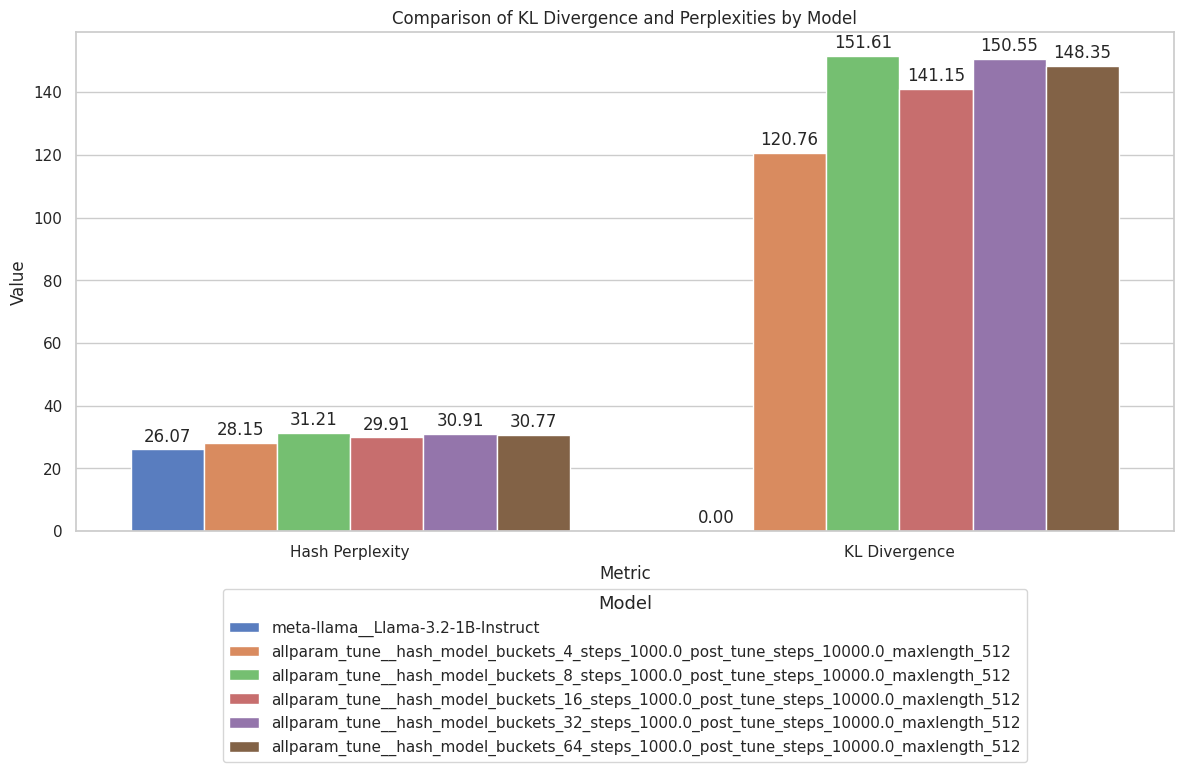

In [113]:
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import List
import numpy as np

def get_metrics(root, paths):
    kl_divs = []
    original_perplexities = []
    hash_perplexities = []
    for path in paths:
        metrics = torch.load(os.path.join(root, path, "metrics.pt"))
        kl_divs.append(np.array(metrics['kl_divergences']).mean())
        original_perplexities.append(np.array(metrics['original_perplexities']).mean())
        hash_perplexities.append(np.array(metrics['hash_perplexities']).mean())
    return kl_divs, original_perplexities, hash_perplexities

def plot_metrics(result_dir, result_paths):
    # Prepare data for grouped bar plot
    kl_divs, original_perplexities, hash_perplexities = get_metrics(result_dir, result_paths)
    data = []
    for i, path in enumerate(result_paths):
        model_name = path.split("__checkpoints__")[-1] if "checkpoints" in path else path
        data.extend([
            {"Metric": "Hash Perplexity", "Model": model_name, "Value": hash_perplexities[i]},
            {"Metric": "KL Divergence", "Model": model_name, "Value": kl_divs[i]}
        ])
    
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=df, x="Metric", y="Value", hue="Model", palette="muted")
    
    # Add value labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3)
    
    plt.title('Comparison of KL Divergence and Perplexities by Model')
    plt.ylabel('Value')
    plt.legend(title='Model', fontsize=11, title_fontsize=13, bbox_to_anchor=(0.5, -0.1), loc='upper center')
    plt.tight_layout()
    plt.show()
    
plot_metrics(result_dir = "eval_results",
             result_paths = ["meta-llama__Llama-3.2-1B-Instruct"] + sorted([i for i in os.listdir("eval_results") if "allparam_tune" in i and "learnable_hash_True" not in i][1:],
                                   key = lambda x: int(x.split("buckets_")[1].split("_")[0])))

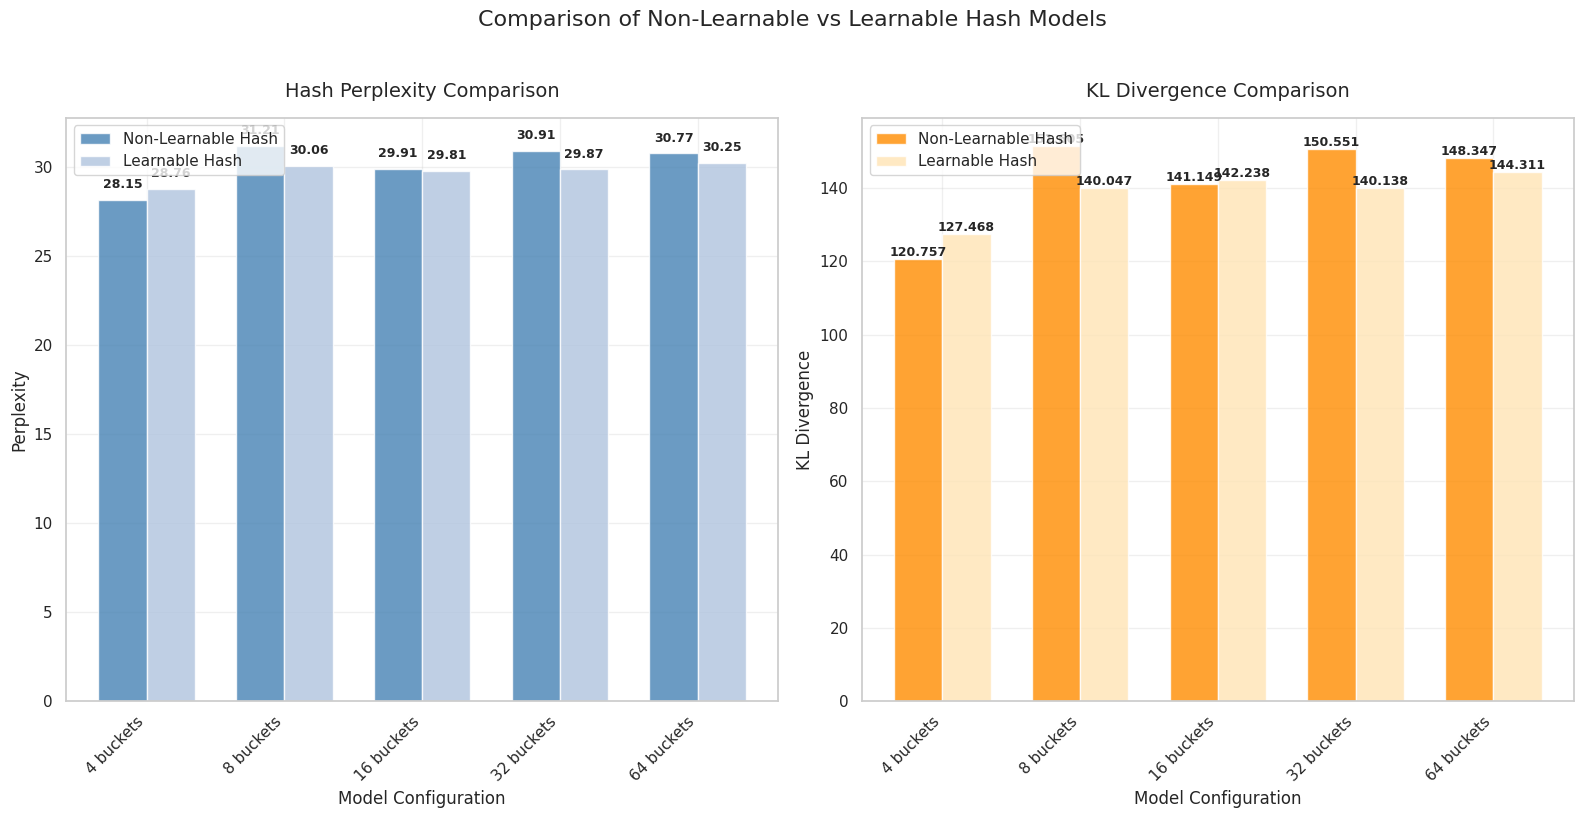

In [112]:
def compare_hash_metrics(result_dir, non_learnable_hash_paths, learnable_hash_paths):
    # Prepare data for grouped bar plot
    kl_divs_non_learnable, original_perplexities_non_learnable, hash_perplexities_non_learnable = get_metrics(result_dir, non_learnable_hash_paths)
    kl_divs_learnable, original_perplexities_learnable, hash_perplexities_learnable = get_metrics(result_dir, learnable_hash_paths)
    
    # Create figure with subplots for each metric
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Extract model names (excluding the base model)
    model_names = []
    for path in non_learnable_hash_paths[1:]:  # Skip base model
        model_name = path.split("__checkpoints__")[-1] if "checkpoints" in path else path
        # Extract bucket number for cleaner labels
        if "buckets_" in model_name:
            bucket_num = model_name.split("buckets_")[1].split("_")[0]
            model_names.append(f"{bucket_num} buckets")
        else:
            model_names.append(model_name)
    
    x_pos = np.arange(len(model_names))
    width = 0.35
    
    # Plot Hash Perplexity
    bars1_non_learnable = ax1.bar(x_pos - width/2, hash_perplexities_non_learnable[1:], width, 
                                 label='Non-Learnable Hash', alpha=0.8, color='steelblue')
    bars1_learnable = ax1.bar(x_pos + width/2, hash_perplexities_learnable[1:], width,
                             label='Learnable Hash', alpha=0.8, color='lightsteelblue')
    
    ax1.set_title('Hash Perplexity Comparison', fontsize=14, pad=15)
    ax1.set_xlabel('Model Configuration', fontsize=12)
    ax1.set_ylabel('Perplexity', fontsize=12)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars1_non_learnable):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    for i, bar in enumerate(bars1_learnable):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # Plot KL Divergence
    bars2_non_learnable = ax2.bar(x_pos - width/2, kl_divs_non_learnable[1:], width,
                                 label='Non-Learnable Hash', alpha=0.8, color='darkorange')
    bars2_learnable = ax2.bar(x_pos + width/2, kl_divs_learnable[1:], width,
                             label='Learnable Hash', alpha=0.8, color='moccasin')
    
    ax2.set_title('KL Divergence Comparison', fontsize=14, pad=15)
    ax2.set_xlabel('Model Configuration', fontsize=12)
    ax2.set_ylabel('KL Divergence', fontsize=12)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(model_names, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars2_non_learnable):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    for i, bar in enumerate(bars2_learnable):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.suptitle('Comparison of Non-Learnable vs Learnable Hash Models', 
                 fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
compare_hash_metrics(result_dir = "eval_results",
             non_learnable_hash_paths = ["meta-llama__Llama-3.2-1B-Instruct"] + sorted([i for i in os.listdir("eval_results") if "allparam_tune" in i and "learnable_hash_True" not in i][1:],
                                   key = lambda x: int(x.split("buckets_")[1].split("_")[0])),
             learnable_hash_paths = ["meta-llama__Llama-3.2-1B-Instruct"] + sorted([i for i in os.listdir("eval_results") if "allparam_tune" in i and "learnable_hash_True" in i and "steps_1000" in i],
                                   key = lambda x: int(x.split("buckets_")[1].split("_")[0])))

### Downstream Task Metrics

In [78]:
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import List

def extract_results(model_dir, model_path):
    model_results_path = [f for f in os.listdir(os.path.join(model_dir, model_path)) if f.startswith("results")][0]
    full_path = os.path.join(model_dir, model_path, model_results_path)
    model_results = json.load(open(full_path))
    extracted_data = []
    for task_name, task_metrics in model_results["results"].items():
        accuracy = task_metrics.get("acc,none")
        if accuracy is not None:
            extracted_data.append({
                "Task": task_name,
                "Model": model_path.split("__checkpoints__")[-1] if "checkpoints" in model_path else model_path,
                "Accuracy (acc,none)": float(accuracy) # Ensure accuracy is float
            })
        else:
            print(f"Warning: 'acc,none' not found for task '{task_name}' in model '{full_path}'.")
    return extracted_data

def plot_results(result_dir: str, result_paths: List[str]):
    all_data = []
    for path in result_paths:
        all_data.extend(extract_results(result_dir, path))
    df = pd.DataFrame(all_data)

    plt.figure(figsize=(16, 12)) # Increased figure size for better label spacing
    sns.set_theme(style="whitegrid")

    ax = sns.barplot(x="Task", y="Accuracy (acc,none)", hue="Model", data=df, palette="muted")

    plt.title('Downstream Task Performance', fontsize=18, pad=20)
    plt.xlabel('Task', fontsize=15, labelpad=-12)
    plt.ylabel('Accuracy', fontsize=15, labelpad=15)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)

    # Move legend outside plot area
    plt.legend(title='Model', fontsize=11, title_fontsize=13, bbox_to_anchor=(0.5, -0.3), loc='upper center')

    # Add value labels on top of each bar
    for p in ax.patches:
        if p.get_height() > 0: # Only annotate bars with height > 0
            ax.annotate(format(p.get_height(), '.3f'), 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha = 'center', va = 'center', 
                            xytext = (0, 9), 
                            textcoords = 'offset points',
                            fontsize=9,
                            color='black')

    # Adjust layout to prevent labels from overlapping
    plt.tight_layout(rect=[0, 0, 1, 0.9]) # Adjust rect to make space for title

    # Display the plot
    plt.show()

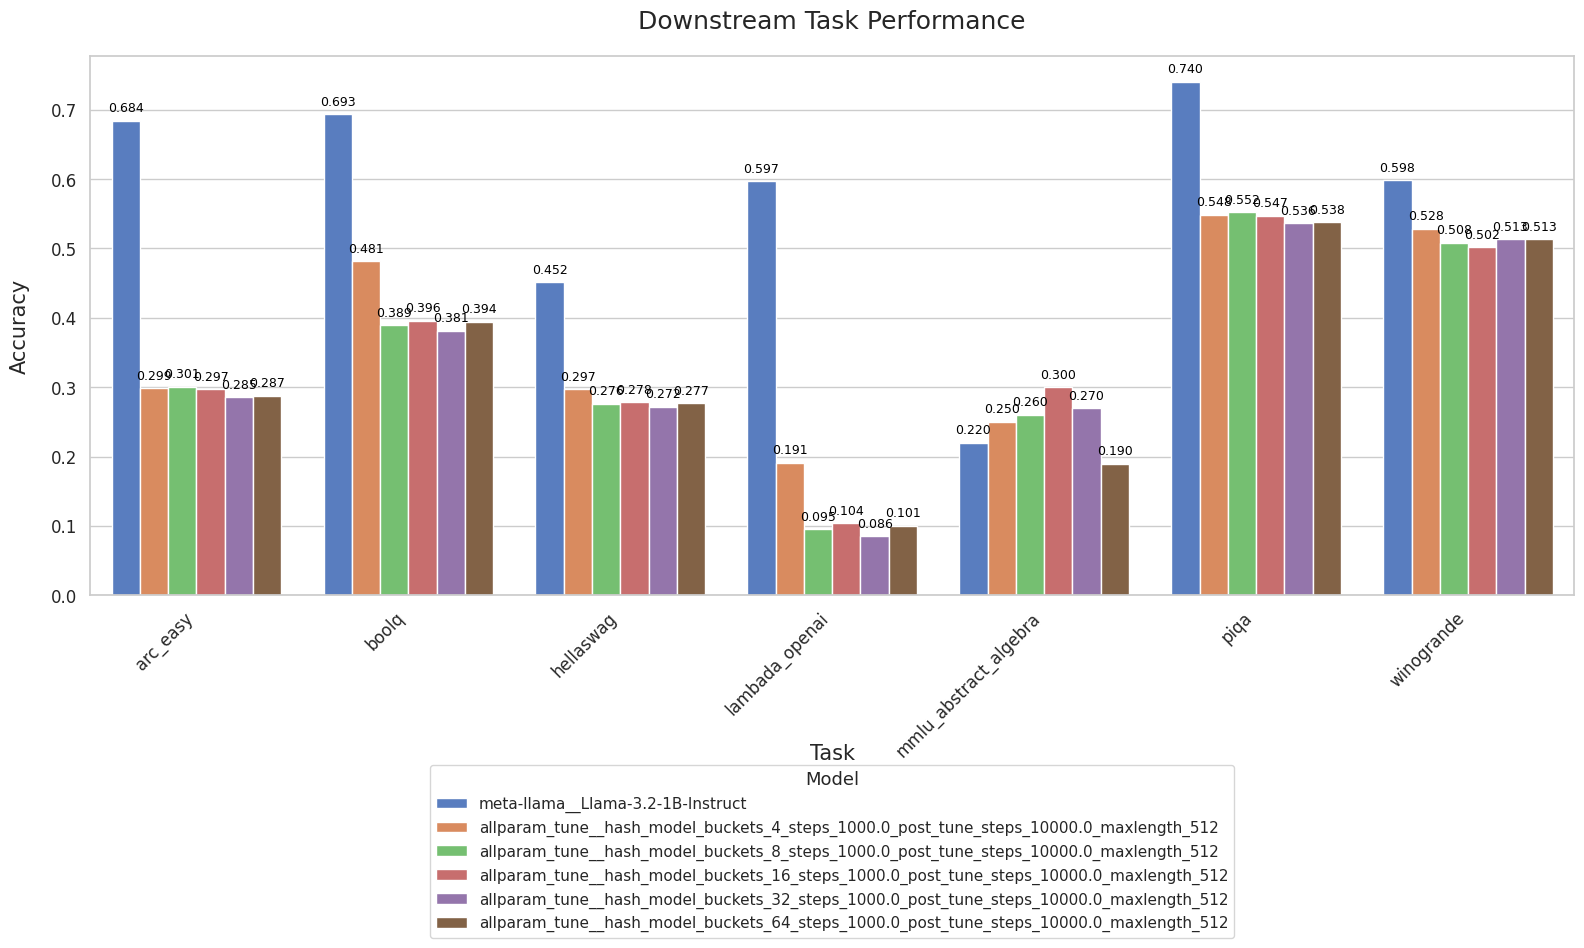

In [79]:
plot_results(result_dir = "eval_results",
             result_paths = ["meta-llama__Llama-3.2-1B-Instruct"] + sorted([i for i in os.listdir("eval_results") if "allparam_tune" in i and "learnable_hash_True" not in i][1:],
                                   key = lambda x: int(x.split("buckets_")[1].split("_")[0])))

### Does Extra Training Help?

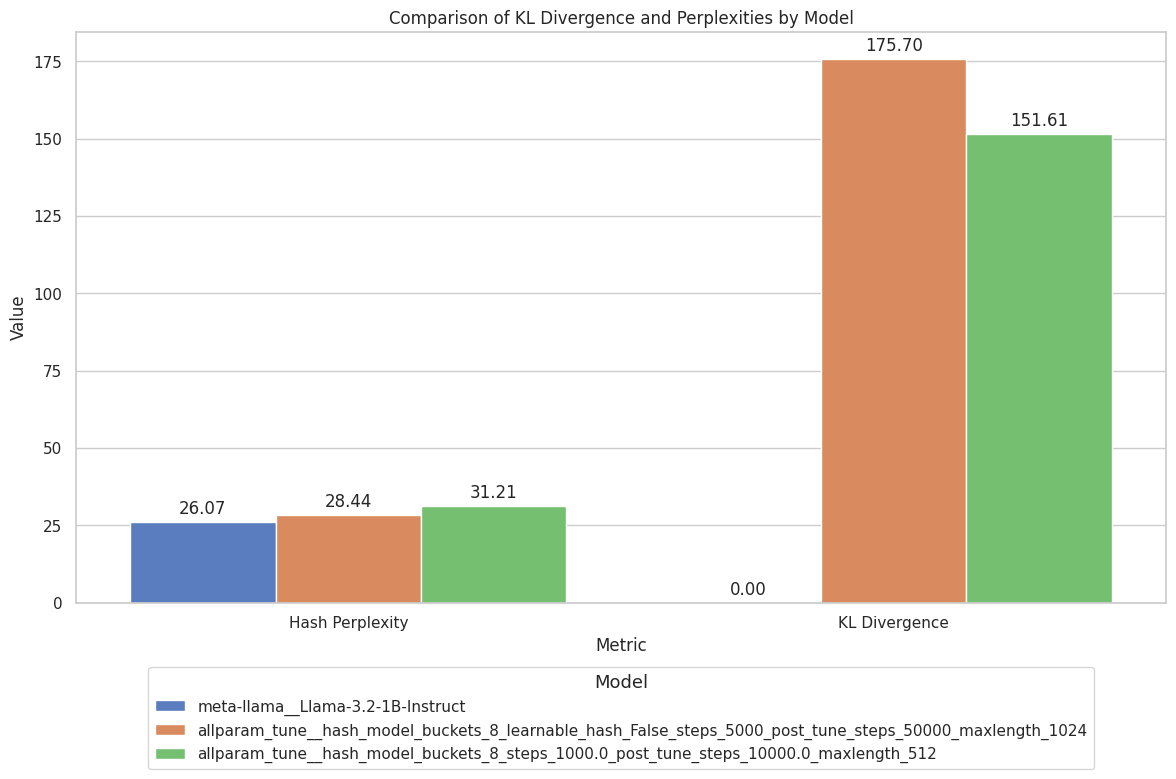

In [120]:
plot_metrics(result_dir = "eval_results",
             result_paths = ["meta-llama__Llama-3.2-1B-Instruct"] + sorted([i for i in os.listdir("eval_results") if "allparam_tune" in i and "learnable_hash_True" not in i and "buckets_8" in i],
                                   key = lambda x: -float(x.split("steps_")[1].split("_")[0])))

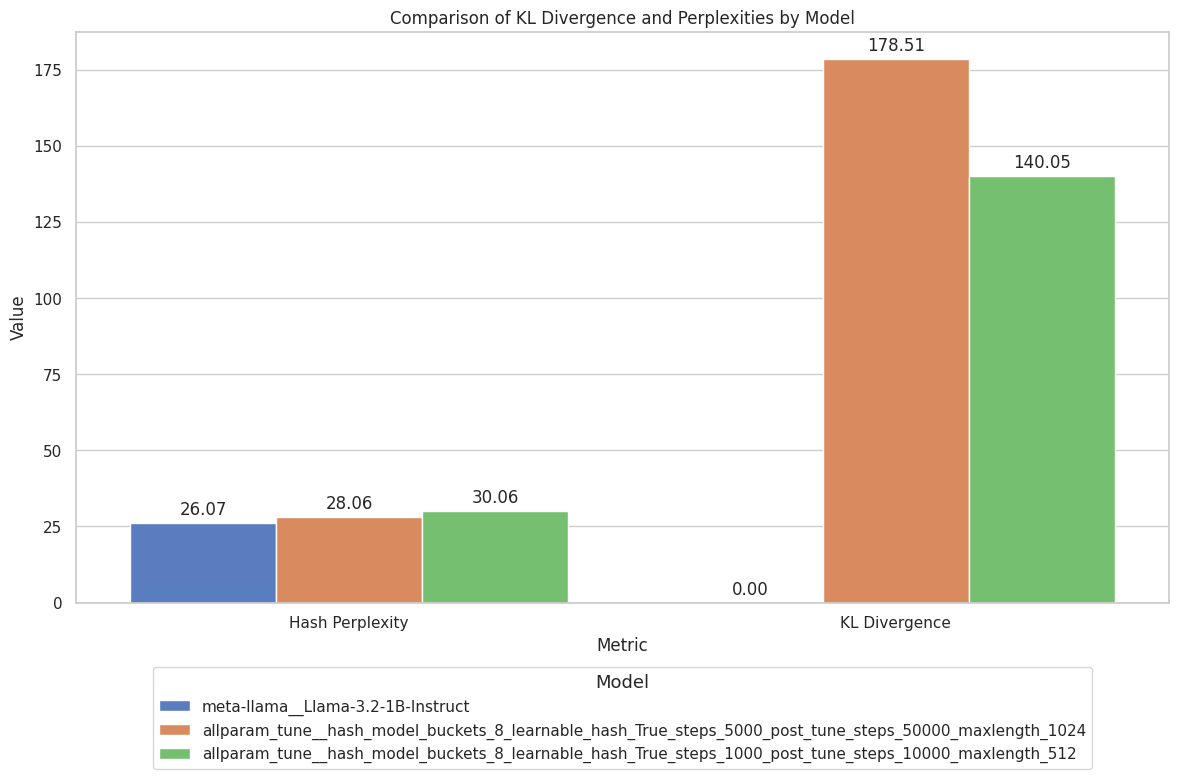

In [121]:
plot_metrics(result_dir = "eval_results",
             result_paths = ["meta-llama__Llama-3.2-1B-Instruct"] + sorted([i for i in os.listdir("eval_results") if "allparam_tune" in i and "learnable_hash_True" in i and "buckets_8" in i],
                                   key = lambda x: -float(x.split("steps_")[1].split("_")[0])))


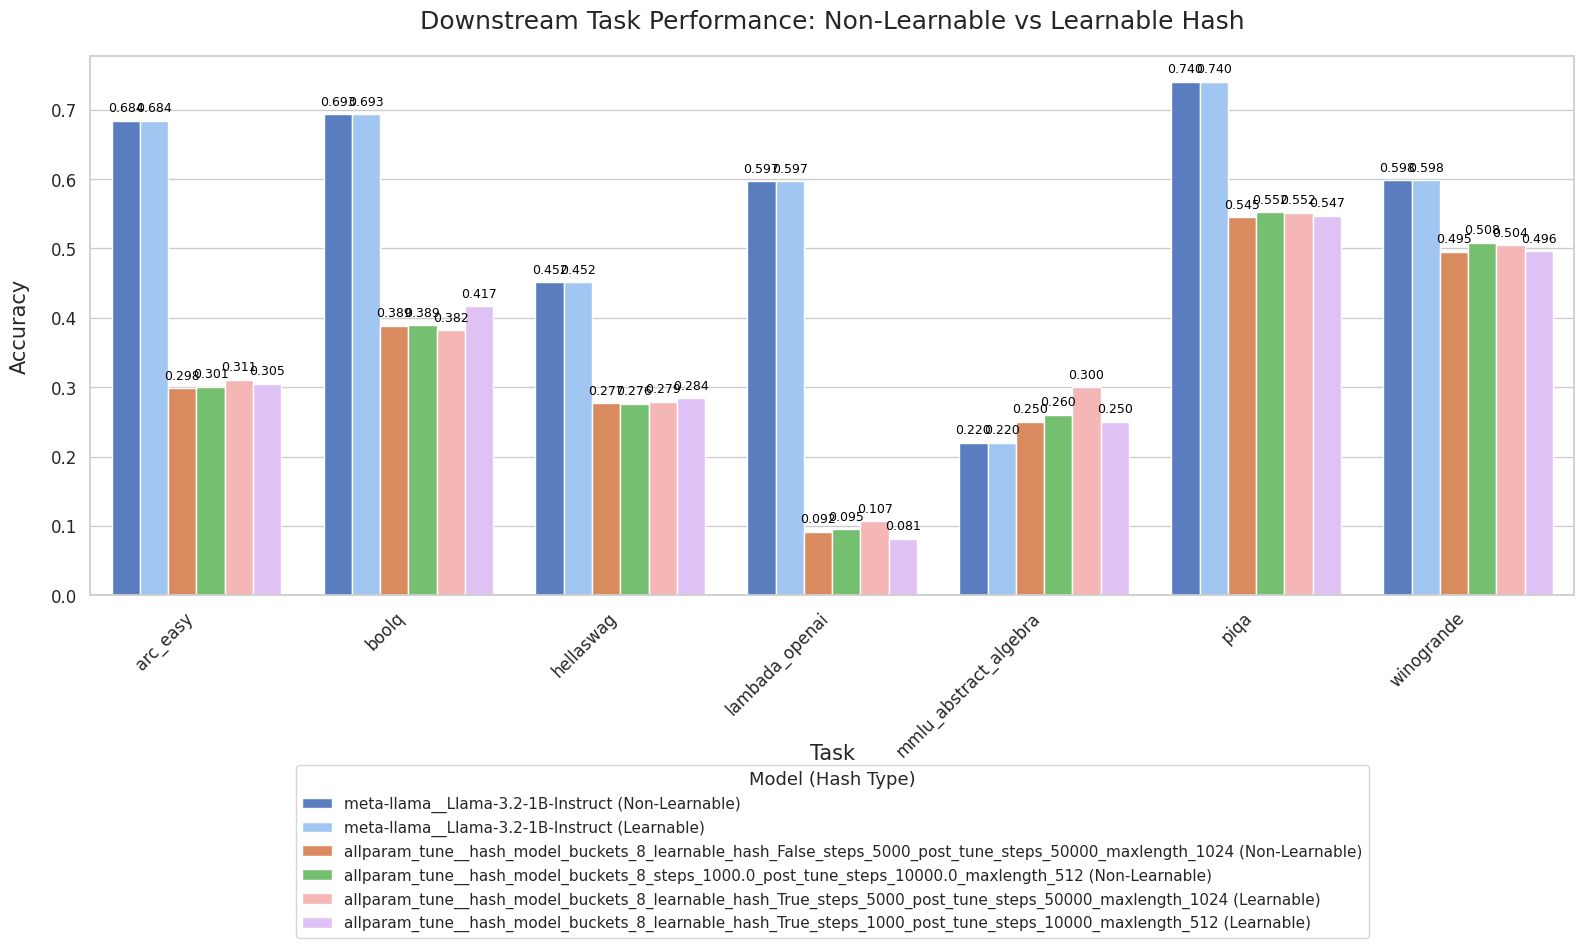

In [123]:
def compare_downstream_metrics(result_dir: str, non_learnable_hash_paths: List[str], learnable_hash_paths: List[str]):
    # Collect data from both non-learnable and learnable hash paths
    all_data = []
    
    # Add non-learnable hash data
    for path in non_learnable_hash_paths:
        data = extract_results(result_dir, path)
        for item in data:
            item['Hash Type'] = 'Non-Learnable'
        all_data.extend(data)
    
    # Add learnable hash data
    for path in learnable_hash_paths:
        data = extract_results(result_dir, path)
        for item in data:
            item['Hash Type'] = 'Learnable'
        all_data.extend(data)
    
    df = pd.DataFrame(all_data)

    plt.figure(figsize=(16, 12)) # Increased figure size for better label spacing
    sns.set_theme(style="whitegrid")

    # Create a combined hue column for grouping
    df['Model_Hash'] = df['Model'] + ' (' + df['Hash Type'] + ')'
    
    # Create custom palette with darker colors for non-learnable and lighter for learnable
    unique_models = df['Model'].unique()
    base_colors = sns.color_palette("muted", len(unique_models))
    palette = {}
    
    for i, model in enumerate(unique_models):
        # Darker color for non-learnable
        palette[f"{model} (Non-Learnable)"] = base_colors[i]
        # Lighter color for learnable (increase brightness)
        lighter_color = tuple(min(1.0, c + 0.3) for c in base_colors[i])
        palette[f"{model} (Learnable)"] = lighter_color

    # Sort the dataframe to ensure non-learnable and learnable pairs are grouped together
    df['Model_Order'] = df['Model'].map({model: i for i, model in enumerate(unique_models)})
    df['Hash_Order'] = df['Hash Type'].map({'Non-Learnable': 0, 'Learnable': 1})
    df = df.sort_values(['Task', 'Model_Order', 'Hash_Order'])

    ax = sns.barplot(x="Task", y="Accuracy (acc,none)", hue="Model_Hash", data=df, palette=palette, dodge=True)

    plt.title('Downstream Task Performance: Non-Learnable vs Learnable Hash', fontsize=18, pad=20)
    plt.xlabel('Task', fontsize=15, labelpad=-12)
    plt.ylabel('Accuracy', fontsize=15, labelpad=15)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(fontsize=12)

    # Move legend outside plot area
    plt.legend(title='Model (Hash Type)', fontsize=11, title_fontsize=13, bbox_to_anchor=(0.5, -0.3), loc='upper center')

    # Add value labels on top of each bar
    for p in ax.patches:
        if p.get_height() > 0: # Only annotate bars with height > 0
            ax.annotate(format(p.get_height(), '.3f'), 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha = 'center', va = 'center', 
                            xytext = (0, 9), 
                            textcoords = 'offset points',
                            fontsize=9,
                            color='black')

    # Adjust layout to prevent labels from overlapping
    plt.tight_layout(rect=[0, 0, 1, 0.9]) # Adjust rect to make space for title

    # Display the plot
    plt.show()
compare_downstream_metrics(result_dir = "eval_results",
             non_learnable_hash_paths = ["meta-llama__Llama-3.2-1B-Instruct"] + sorted([i for i in os.listdir("eval_results") if "allparam_tune" in i and "learnable_hash_True" not in i and "buckets_8" in i],
                                   key = lambda x: -float(x.split("steps_")[1].split("_")[0])),
             learnable_hash_paths = ["meta-llama__Llama-3.2-1B-Instruct"] + sorted([i for i in os.listdir("eval_results") if "allparam_tune" in i and "learnable_hash_True" in i and "buckets_8" in i],
                                   key = lambda x: -float(x.split("steps_")[1].split("_")[0])))